# REGRESSION CLASS MODEL

ive been thinking, the y target is the density but we dont have real bus_stop_count in production, so we wont be able to predict density with the classification model since an entire feature is missing. which means we will need another model to predict the amount of students at the bus stop based on the class data. i built the time series model but the results were very bad:


    New MAE: 133.22 (Previously 136.78)

    New RMSE: 161.54 (Previously 164.93)

Interpretation of the Change:

    Slight Improvement: Both the MAE and RMSE have decreased slightly. This indicates that the data cleaning steps you performed have led to a marginal improvement in the model's predictive accuracy on the test set. The model's average error (MAE) is now about 133 units, and the error metric that penalizes larger errors more (RMSE) is about 162 units.

    Magnitude: The reduction in error is relatively small (MAE decreased by ~3.5 points, RMSE by ~3.4 points).

    Visuals Likely Similar: Given the small change in metrics, the visual plot of the forecast vs. actuals on the test set probably looks very similar to the previous one you shared. The fundamental characteristics likely remain:

        The model probably still captures the general trend.

        It likely still smooths over the short-term volatility.

        Most actual points probably still fall within the uncertainty interval, but the most extreme peaks/dips might still be missed or lie near the boundary.

Conclusion:

Your data cleaning efforts were beneficial, resulting in a slightly more accurate forecast according to the test set metrics. However, the improvement is minor, suggesting that the core challenges in predicting this time series (likely the volatility and sharp peaks/dips within the daily pattern) weren't fully addressed by the cleaning alone.

If this level of accuracy is still not sufficient, the next steps would likely involve:

    Prophet Parameter Tuning: Adjusting parameters like changepoint_prior_scale, seasonality_prior_scale, or seasonality_mode.

    Adding Regressors: If external factors influence the y value, adding them as regressors could significantly improve the forecast.

    Considering Alternative Models: If Prophet continues to struggle with the volatility, exploring other time series models (like ARIMA, Exponential Smoothing, or even machine learning models like LSTMs if you have enough data) might be worthwhile.

so im thinking about using a regression model or something similar to predict the student numbers, what do you think?

You're thinking in exactly the right direction. Let's break this down together and carve a clear path forward:

---

### 🔍 **Problem Summary**

You're currently:

- **Classifying `density`** levels using features like `bus_stop_count` – works *great*, but you **won’t have `bus_stop_count` in production**.
- You **tried time series forecasting (Prophet)** to predict `bus_stop_count`, but it's struggling with sharp peaks/volatility.
- You're now thinking of **using a regression model** to predict `bus_stop_count` from *known scheduling data*, instead of time series.

---

### ✅ **Yes – Regression Makes Sense**

This is a smart move for your case. Why?

- You already have features like:
  - `day_encoded`
  - `time_slot_minutes`
  - Possibly class-specific features (like number of classes scheduled, break durations, etc.)
- These **don't rely on historical `bus_stop_count`**, which is what you want in a real-time scenario.
- You don’t need temporal continuity for regression to work well – **just a strong mapping from features → `bus_stop_count`**.

---

### 🔮 Regression Pipeline Idea

1. **Input Features** (features you can generate in real-time):
   - `day_encoded`
   - `time_slot_minutes`
   - `num_classes_starting`
   - `num_classes_ending`
   - Maybe location or faculty if available?

2. **Target**:
   - `bus_stop_count` (continuous – so it’s a regression task)

3. **Model Options**:
   - Start simple: `LinearRegression`, `RandomForestRegressor`
   - Then try: `GradientBoostingRegressor`, `XGBoost`, `CatBoost`
   - If your data volume is large, maybe even a neural net (like a small MLP)

---

### 🧠 And Then...

- **Feed the output of the regression model (predicted `bus_stop_count`)** into your classification model to get `density`.
- This allows your **classification model to stay intact** — just shift where the `bus_stop_count` comes from.

---

### 📦 Bonus: Hybrid Model Workflow

```mermaid
graph TD;
    A[Real-time schedule info] --> B[Regression Model: Predict bus_stop_count]
    B --> C[Classification Model: Predict density]
    C --> D[Send prediction to web app or dashboard]
```

---

### 🧪 Next Steps

1. Train a regression model (Random Forest is a good baseline) on your cleaned dataset.
2. Check metrics: MAE, RMSE – but also scatter plot predicted vs. actual.
3. If that performs better than Prophet (which seems likely in this case), **drop Prophet from the stack** and keep this regression model as the main feeder into your classifier.

---

Let me know if you want help building or testing the regression model — I can walk you through it or generate the code.

which do you think is better, making a regression model or taking the current time converting it into mins from midnight and then taking it directly from the dataset we used to train the classification model? 

This is a *really good* question — it boils down to **predictive flexibility vs. simplicity**.

Let’s compare the two clearly:

---

## 🔁 **Option 1: Regression Model (Predict `bus_stop_count`)**

### ✅ Pros:
- **Generalizable**: Predicts bus stop count for *any* time input, even unseen combinations of day + time.
- **No need for exact matches** in your dataset (i.e., it's not just a lookup).
- Can incorporate **more features** (class load, weather, event days, etc.) to improve accuracy later.
- Works better in **real-time systems**, especially with slight delays or asynchronous queries.

### ❌ Cons:
- Needs training and tuning.
- Might slightly mispredict (depends on model quality).
- Adds more complexity.

---

## 🕐 **Option 2: Time Lookup (Use `time_slot_minutes` + `day` to get existing bus_stop_count)**

### ✅ Pros:
- **Super simple**: It’s just a lookup.
- **100% accurate** — if that time and day exist in the dataset.
- No model training or risk of error.

### ❌ Cons:
- **Not flexible**:
  - If the time isn’t in the dataset (e.g., you query at 10:03 but only have 10:00 and 10:05), you get nothing unless you interpolate.
- **Can’t generalize** to new days/times/schedule changes.
- Doesn’t improve with more data (it’s static).

---

## 🧠 TL;DR — Which is Better?

| Use Case | Best Option |
|----------|-------------|
| You need real-time predictions that are robust to missing time slots or future scheduling changes | ✅ **Regression** |
| You only need predictions for known, fixed time slots (like a dashboard that runs on a strict schedule) | ✅ **Lookup** |

---

### 🔧 Pro Tip: Combine Both (Fallback Plan)
Use the **lookup approach as a first try**, and if the exact time isn’t found, **fallback to the regression model**.

```python
def get_bus_stop_count(day, time_minutes, data, regression_model=None, fallback=True):
    match = data[(data['day'] == day) & (data['time_slot_minutes'] == time_minutes)]
    if not match.empty:
        return match.iloc[0]['bus_stop_count']
    elif fallback and regression_model:
        # Assume day is already encoded
        return regression_model.predict([[day_encoded, time_minutes]])[0]
    else:
        return None
```

---

Would you like help building that fallback logic or comparing both approaches in practice with your data?

In [134]:
import pandas as pd
import sqlite3
from data_collections.constants import SQLITE_DATABASE_MODEL

In [135]:
TABLE_NAME = "course_info" 

In [136]:
connection = sqlite3.connect(SQLITE_DATABASE_MODEL)
c = connection.cursor()

In [137]:
obs_data = pd.read_sql_query(f'SELECT * FROM {TABLE_NAME}', connection)

In [138]:
data = obs_data.copy()

In [139]:
data.head()

,faculty_code,faculty,course_code,course_name,class,teacher,year,day,start_time,end_time,student_nums
0,GÖRSEL İLETİŞİM TASARIMI_GSF102,GÖRSEL İLETİŞİM TASARIMI,GSF102,TEMEL TASARIM II,L-102(GİT ATÖLYE II)[60],SEÇİL KARTOPU,1,Pazartesi,09:00,14:50,41
1,GÖRSEL İLETİŞİM TASARIMI_GSF106,GÖRSEL İLETİŞİM TASARIMI,GSF106,ÇİZİM II,L-101(GİT ATÖLYE I)[60],Öğr.Gör. İSMAİL FURKAN YAVUZ,1,Pazartesi,09:00,14:50,44
2,GÖRSEL İLETİŞİM TASARIMI_BLG102,GÖRSEL İLETİŞİM TASARIMI,BLG102,BİLGİ TEKNOLOJİLERİ KULLANIMI,AZ 13(BİLGİSAYAR LAB.)[80],Öğr.Gör. AHMET AKSOY,1,Salı,09:00,15:50,44
3,İKTİSAT_ENG104,İKTİSAT,ENG104,ACADEMIC ENGLISH II,B382(KONFERANS SALONU)[143],Öğr.Gör. MÜGE AKGEDİK AKOĞLANOĞLU,1,Pazartesi,09:00,16:50,35
4,İKTİSAT_ECON102,İKTİSAT,ECON102,INTRODUCTION TO ECONOMICS II,B338-D1(DERSLİK1)[121],KORAY GÖKSAL,1,Pazartesi,14:00,16:50,91


In [140]:
print(f'there are {len(data.columns)} columns and {len(data)} rows')

there are 11 columns and 623 rows


### STEP 1: structure the data for the model

In [141]:
# list all the columns to drop

print(data.columns)

Index(['faculty_code', 'faculty', 'course_code', 'course_name', 'class',
       'teacher', 'year', 'day', 'start_time', 'end_time', 'student_nums'],
      dtype='object')


In [142]:
to_drop = ['faculty_code', 'course_name', 'class', 'teacher', 'course_code']

In [143]:
data.drop(labels=to_drop,axis=1, inplace=True)

In [144]:
data

,faculty,year,day,start_time,end_time,student_nums
0,GÖRSEL İLETİŞİM TASARIMI,1,Pazartesi,09:00,14:50,41
1,GÖRSEL İLETİŞİM TASARIMI,1,Pazartesi,09:00,14:50,44
2,GÖRSEL İLETİŞİM TASARIMI,1,Salı,09:00,15:50,44
3,İKTİSAT,1,Pazartesi,09:00,16:50,35
4,İKTİSAT,1,Pazartesi,14:00,16:50,91
...,...,...,...,...,...,...
618,FELSEFE,4,Çarşamba,09.00,11:50,31
619,FELSEFE,4,Çarşamba,09.00,11:50,36
620,FELSEFE,4,Çarşamba,13.00,14:50,23
621,FELSEFE,4,Perşembe,13.00,14:50,19


In [145]:
import pandas as pd

def preprocess_class_data(df_classes):
    # Convert to minutes from midnight
    def time_to_minutes(t):
        if isinstance(t, pd.Timestamp):
            return t.hour * 60 + t.minute
        elif isinstance(t, str):
            t = t.replace('.', ':')  # Handle "09.00" format
            h, m = map(int, t.split(':'))
            return h * 60 + m
        else:
            raise ValueError(f"Unsupported time format: {t}")


    df = df_classes.copy()
    df['end_time_minutes'] = df['end_time'].apply(time_to_minutes)
    df['start_time_minutes'] = df['start_time'].apply(time_to_minutes)

    # Group by day and end time (to match your time slot format)
    agg_df = df.groupby(['day', 'end_time_minutes']).agg(
        num_classes=('faculty', 'count'),
        total_students=('student_nums', 'sum'),
        most_common_faculty=('faculty', lambda x: x.mode()[0] if not x.mode().empty else None),
        avg_duration=('start_time_minutes', lambda x: (x.max() - x.min())),
        num_year_1=('year', lambda x: (x == 1).sum()),
        num_year_2=('year', lambda x: (x == 2).sum()),
        num_year_3=('year', lambda x: (x == 3).sum()),
        num_year_4=('year', lambda x: (x == 4).sum())
    ).reset_index()

    return agg_df


In [146]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [147]:
import pandas as pd
from datetime import datetime, timedelta

def calculate_bus_stop_counts(df):
    """
    Takes a class schedule DataFrame and returns a new DataFrame with time slots and bus_stop_count.
    Works using minutes-from-midnight as time representation.
    
    Required columns in df:
    - 'day' (e.g., Monday)
    - 'end_time' (string in 'HH:MM' format)
    - 'student_nums' (integer)
    """
    
    # Convert end_time to datetime for parsing, then extract minutes-from-midnight
    df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M')
    df['end_time_minutes'] = df['end_time'].dt.hour * 60 + df['end_time'].dt.minute
    
    time_slots = []

    for _, row in df.iterrows():
        end_time_min = row['end_time_minutes']
        student_count = row['student_nums']
        day = row['day']
        
        # Define departure distribution
        departures = [
            (0, 0.20),  # 0-5 minutes
            (5, 0.50),  # 5-10 minutes
            (10, 0.30)  # 10-15 minutes
        ]

        for offset, fraction in departures:
            slot_min = end_time_min + offset  # Still in minutes-from-midnight
            time_slots.append({
                'day': day,
                'time_slot_minutes': slot_min,
                'bus_stop_count': int(student_count * fraction)
            })

    # Create DataFrame from list of time slots
    result_df = pd.DataFrame(time_slots)

    # Group by day and time slot to sum overlapping students
    result_df = result_df.groupby(['day', 'time_slot_minutes'], as_index=False).sum()
    #result_df['time_slot'] = result_df['time_slot_minutes'].apply(lambda x: f"{x // 60:02}:{x % 60:02}")


    return result_df


In [148]:
data_timeslots = calculate_bus_stop_counts(data)
print(data_timeslots)

          day  time_slot_minutes  bus_stop_count
0        Cuma                650              30
1        Cuma                655              78
2        Cuma                660              46
3        Cuma                710              91
4        Cuma                715             232
..        ...                ...             ...
158  Çarşamba               1075              63
159  Çarşamba               1080              37
160  Çarşamba               1130              36
161  Çarşamba               1135              91
162  Çarşamba               1140              54

[163 rows x 3 columns]


In [149]:
df_classinfo = preprocess_class_data(data)

# Then merge with your time-slot data
df_final = data_timeslots.merge(df_classinfo, how='left',
                             left_on=['day', 'time_slot_minutes'],
                             right_on=['day', 'end_time_minutes'])

# Drop 'end_time_minutes' after merge if you want
df_final.drop(columns=['end_time_minutes'], inplace=True)

In [150]:
df_final

,day,time_slot_minutes,bus_stop_count,num_classes,total_students,most_common_faculty,avg_duration,num_year_1,num_year_2,num_year_3,num_year_4
0,Cuma,650,30,3.0,156.0,TARİH,60.0,1.0,2.0,0.0,0.0
1,Cuma,655,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cuma,660,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cuma,710,91,9.0,470.0,FELSEFE,120.0,2.0,3.0,3.0,1.0
4,Cuma,715,232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
158,Çarşamba,1075,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,Çarşamba,1080,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,Çarşamba,1130,36,1.0,183.0,MİMARLIK(İNG),0.0,0.0,1.0,0.0,0.0
161,Çarşamba,1135,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
def fill_smart(df):
    df = df.sort_values(by=['day', 'time_slot_minutes'])

    # Forward fill categorical
    df['most_common_faculty'] = df.groupby('day')['most_common_faculty'].ffill()

    # Smooth numeric
    numeric_cols = ['num_classes', 'total_students', 'avg_duration',
                    'num_year_1', 'num_year_2', 'num_year_3', 'num_year_4']

    for col in numeric_cols:
        df[col] = df.groupby('day')[col].transform(lambda x: x.fillna(x.rolling(3, min_periods=1, center=True).mean()))
    
    return df


In [152]:
data = fill_smart(df_final)

In [153]:
data

,day,time_slot_minutes,bus_stop_count,num_classes,total_students,most_common_faculty,avg_duration,num_year_1,num_year_2,num_year_3,num_year_4
0,Cuma,650,30,3.0,156.0,TARİH,60.0,1.0,2.0,0.0,0.0
1,Cuma,655,78,3.0,156.0,TARİH,60.0,1.0,2.0,0.0,0.0
2,Cuma,660,46,9.0,470.0,TARİH,120.0,2.0,3.0,3.0,1.0
3,Cuma,710,91,9.0,470.0,FELSEFE,120.0,2.0,3.0,3.0,1.0
4,Cuma,715,232,9.0,470.0,FELSEFE,120.0,2.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
158,Çarşamba,1075,63,2.0,127.0,FELSEFE,120.0,0.0,1.0,1.0,0.0
159,Çarşamba,1080,37,1.0,183.0,FELSEFE,0.0,0.0,1.0,0.0,0.0
160,Çarşamba,1130,36,1.0,183.0,MİMARLIK(İNG),0.0,0.0,1.0,0.0,0.0
161,Çarşamba,1135,91,1.0,183.0,MİMARLIK(İNG),0.0,0.0,1.0,0.0,0.0


next encoding

In [154]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# one hot encoding for the days column
## we commented it out because the randomforestclassifier does not need one hot encoding

In [155]:
"""
days = pd.get_dummies(data['day'], prefix='day')
new_drop = ['day']
data.drop(labels=new_drop, axis=1, inplace=True)
_d = days.apply(le.fit_transform)
data = data.join(_d)
"""

"\ndays = pd.get_dummies(data['day'], prefix='day')\nnew_drop = ['day']\ndata.drop(labels=new_drop, axis=1, inplace=True)\n_d = days.apply(le.fit_transform)\ndata = data.join(_d)\n"

In [156]:
data

,day,time_slot_minutes,bus_stop_count,num_classes,total_students,most_common_faculty,avg_duration,num_year_1,num_year_2,num_year_3,num_year_4
0,Cuma,650,30,3.0,156.0,TARİH,60.0,1.0,2.0,0.0,0.0
1,Cuma,655,78,3.0,156.0,TARİH,60.0,1.0,2.0,0.0,0.0
2,Cuma,660,46,9.0,470.0,TARİH,120.0,2.0,3.0,3.0,1.0
3,Cuma,710,91,9.0,470.0,FELSEFE,120.0,2.0,3.0,3.0,1.0
4,Cuma,715,232,9.0,470.0,FELSEFE,120.0,2.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
158,Çarşamba,1075,63,2.0,127.0,FELSEFE,120.0,0.0,1.0,1.0,0.0
159,Çarşamba,1080,37,1.0,183.0,FELSEFE,0.0,0.0,1.0,0.0,0.0
160,Çarşamba,1130,36,1.0,183.0,MİMARLIK(İNG),0.0,0.0,1.0,0.0,0.0
161,Çarşamba,1135,91,1.0,183.0,MİMARLIK(İNG),0.0,0.0,1.0,0.0,0.0


In [157]:
data.to_csv('day_time_stop.csv')

In [158]:
le = LabelEncoder()

In [159]:
data['day_encoded'] = le.fit_transform(data['day'])

In [160]:
#faculty_freq = data['most_common_faculty'].value_counts(normalize=True)
#data['faculty_freq'] = data['most_common_faculty'].map(faculty_freq)

data['most_common_faculty_encoded'] = le.fit_transform(data['most_common_faculty'])

In [161]:
ctd = ['day', 'most_common_faculty', 'num_year_1', 'num_year_2',
        'num_year_3', 'num_year_4']

In [162]:
data = data.drop(columns=ctd)


In [163]:
data

,time_slot_minutes,bus_stop_count,total_students,avg_duration,day_encoded,most_common_faculty_encoded
0,650,30,156.0,60.0,0,14
1,655,78,156.0,60.0,0,14
2,660,46,470.0,120.0,0,14
3,710,91,470.0,120.0,0,4
4,715,232,470.0,120.0,0,4
...,...,...,...,...,...,...
158,1075,63,127.0,120.0,4,4
159,1080,37,183.0,0.0,4,4
160,1130,36,183.0,0.0,4,9
161,1135,91,183.0,0.0,4,9


In [164]:
data.ffill(inplace=True)

In [165]:
data.to_csv('i_regression.csv')

## model

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
X = data.drop(labels=['bus_stop_count'], axis=1)
y = data['bus_stop_count']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import xgboost as xgb

In [170]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('RandomForestRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')

RandomForestRegressor:

mean absolute error = 104.74181818181819
mean absolute percentage error = 1.3530668408411963
mean squared error = 24909.60613333334
root mean squared error = 157.82777364372006
r2 score = 0.7399961990427388


In [171]:
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.3, max_depth=5, subsample=0.8)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('GradientBoostingRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')

GradientBoostingRegressor:

mean absolute error = 77.76291833093971
mean absolute percentage error = 1.1442808448514947
mean squared error = 9311.940972768809
root mean squared error = 96.49839880935232
r2 score = 0.902802957451437


In [172]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('LinearRegression:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')

LinearRegression:

mean absolute error = 180.61243868415715
mean absolute percentage error = 1.7912675267828377
mean squared error = 84583.19072380991
root mean squared error = 290.8318942685102
r2 score = 0.1171297142328348


In [173]:
model = PoissonRegressor()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('PoissonRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')

PoissonRegressor:

mean absolute error = 206.35547785547786
mean absolute percentage error = 2.73314117800507
mean squared error = 96317.72016675633
root mean squared error = 310.35096289000995
r2 score = -0.0053540473039712655


c:\Users\Owner\miniconda3\envs\senior\Lib\site-packages\sklearn\linear_model\_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


In [174]:
model = GaussianProcessRegressor(alpha=0.3)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('GaussianProcessRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')

GaussianProcessRegressor:

mean absolute error = 222.3632870658787
mean absolute percentage error = 0.999998039457393
mean squared error = 145250.14615425174
root mean squared error = 381.1169717478503
r2 score = -0.5161054690128688


In [175]:
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')

XGBRegressor:

mean absolute error = 72.69384765625
mean absolute percentage error = 1.0655218362808228
mean squared error = 9627.3662109375
root mean squared error = 98.119140625
r2 score = 0.8995105624198914


XGBRegressor:

mean absolute error = 78.1384048461914
mean absolute percentage error = 1.050711750984192
mean squared error = 13610.11328125
root mean squared error = 116.66239166259766
r2 score = 0.8579390645027161


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

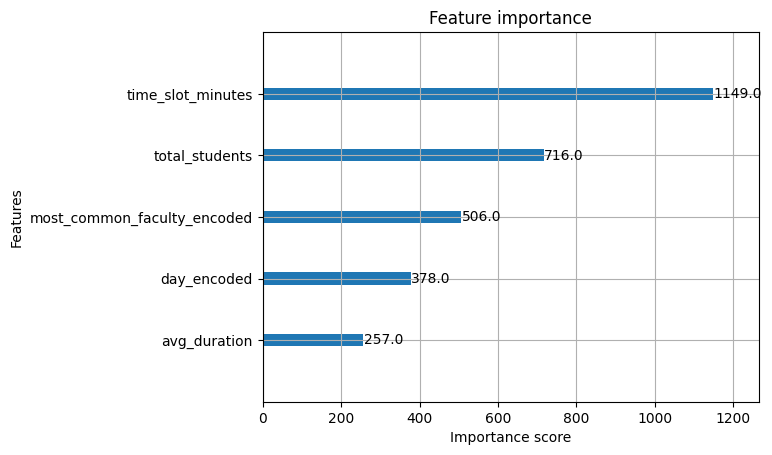

In [176]:
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.9,
    max_depth=90,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0
)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')
from xgboost import plot_importance
plot_importance(model)


XGBRegressor:

mean absolute error = 72.16636657714844
mean absolute percentage error = 0.91720050573349
mean squared error = 11330.541015625
root mean squared error = 106.44501495361328
r2 score = 0.8817330002784729


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

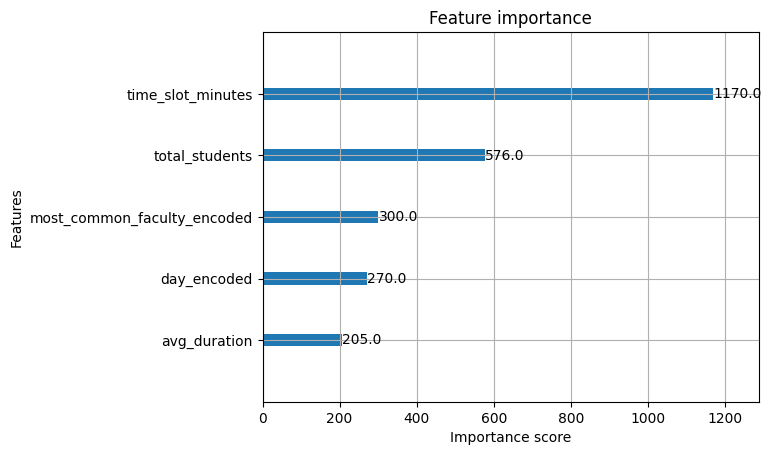

In [177]:
model = xgb.XGBRegressor(
    n_estimators=50,
    learning_rate=0.5,
    max_depth=60,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0
)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(y_test, y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(y_test, y_predict)}')
print(f'mean squared error = {mean_squared_error(y_test, y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(y_test, y_predict)}')
print(f'r2 score = {r2_score(y_test, y_predict)}')
from xgboost import plot_importance
plot_importance(model)
